# 汎用データからQELM <br>
<br>
データ点数N=150(load_iris) <br>
$U(\mathbf{x})$  量子エンコード ; def U_x(x) 　　[N, FEATURE_NUM] -> 量子回路qc <br>
$O$ : 観測値　; counts <br>
$\langle O \rangle$ : 期待値　; expectations　 <br>

変数定義

In [67]:
SIMULATOR_SHOT = 1024 # 量子回路をシミュレーションする回数
FEATURE_NUM = 2 #分類に用いる特徴量

TEST_SIZE = 0.2 #評価する際のtestデータ数の割合
TRIAL_NUM = 30 #QELMやELMの試験回数

関数の準備

In [58]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np

"""特徴量xから量子回路を作成し、測定を追加する"""
def U_x(x):
    num_qubits = len(x)
    qc = QuantumCircuit(num_qubits, num_qubits)  # 古典レジスタも作る
    for i in range(num_qubits):
        qc.ry(x[i], i)
    qc.measure(range(num_qubits), range(num_qubits))  # 全量子ビットを測定
    return qc

"""回路qcをシミュレータで実行して期待値を計算"""
def compute_expectations(qc, shots=1024):
    simulator = AerSimulator()
    result = simulator.run(qc, shots=shots).result()
    counts = result.get_counts()
    
    num_qubits = qc.num_qubits
    expectations = np.zeros(num_qubits)
    total_shots = sum(counts.values())

    for bitstring, cnt in counts.items():
        for i, bit in enumerate(reversed(bitstring)):  # ビット順は逆
            if bit == '0':
                expectations[i] += cnt
            else:
                expectations[i] -= cnt
    expectations /= total_shots
    return expectations


データセットの準備 汎用データを𝑥 ∈ [0, π]スケーリング

In [59]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import numpy as np

# データロード
iris = load_iris()
X = iris.data[:, :FEATURE_NUM]  # 最初の2特徴だけ取る
Y = iris.target

# 標準化（オプション）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# スケーリング（回転角に合わせて調整）
X_encoded = (X_scaled - X_scaled.min()) / (X_scaled.max() - X_scaled.min()) * np.pi

print("X_encoded.shape:", X_encoded.shape)
print("X_encoded[0]:", X_encoded[0])#例えばどういう値があるかの確認
print("true value Y:", Y)



X_encoded.shape: (150, 2)
X_encoded[0]: [0.87188039 1.96349541]
true value Y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


UMAPで可視化

X_umap.shape: (150, 2)


/home/yu_iana/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


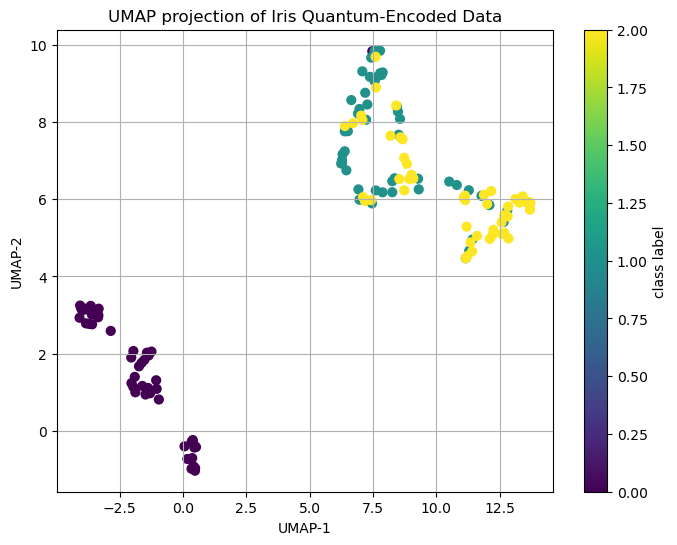

In [60]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# --- UMAPで次元削減 ---
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_encoded)

print("X_umap.shape:", X_umap.shape)  # (150, 2) になるはず

# --- プロット ---
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_umap[:,0], X_umap[:,1], c=Y, cmap='viridis', s=40)
plt.colorbar(scatter, label='class label')
plt.title("UMAP projection of Iris Quantum-Encoded Data")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()

# ここからQELM
エンコード回路作成 U(x)の作成, 

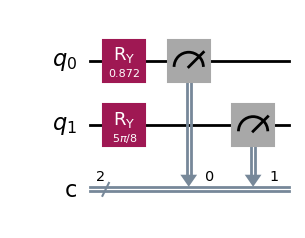

In [61]:
qc = U_x(X_encoded[0]) # 特徴量の数 = Q bit(初期値は0)の回路を作成
qc.draw('mpl') # 回路を描画

In [62]:
# シミュレータで実行
simulator = AerSimulator()  # methodはautomaticでOK
result = simulator.run(qc, shots=SIMULATOR_SHOT).result()

# 測定結果カウントを取得
counts = result.get_counts()
print("実際に観測した各ビットの値")
print(counts)

実際に観測した各ビットの値
{'11': 130, '01': 53, '10': 603, '00': 238}


各量子ビットの期待値測定 $\langle O \rangle$　<br>
完全に |0⟩ 状態（z軸上向き）だと、期待値 ⟨Z⟩ = +1 <br>
完全に |1⟩ 状態（z軸下向き）だと、期待値 ⟨Z⟩ = -1 <br>
ちょうど真横（x-y平面上）にいるときは、期待値 ⟨Z⟩ = 0 <br>

100%|██████████| 150/150 [00:00<00:00, 329.90it/s]
/home/yu_iana/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Phi.shape: (150, 2)
Phi example [ 0.66015625 -0.38867188]
Phi_umap.shape: (150, 2)


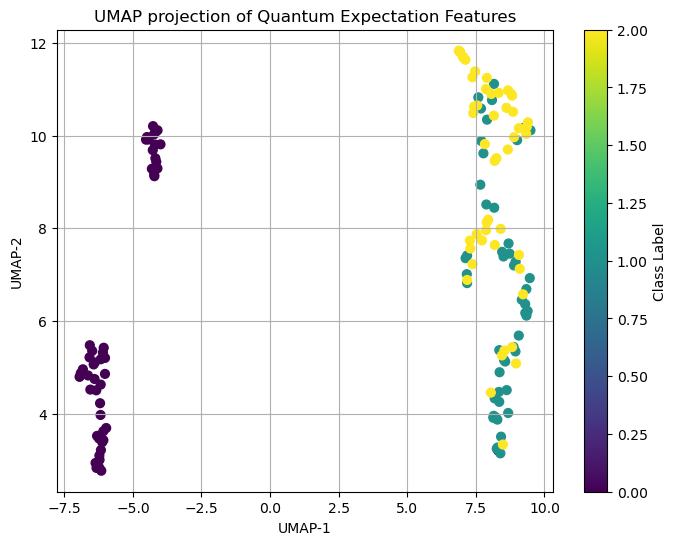

In [63]:
from tqdm import tqdm

# 全データについて期待値を計算
Phi = []

for x in tqdm(X_encoded):
    qc = U_x(x) #各データごとに量子回路作成
    expectations = compute_expectations(qc, SIMULATOR_SHOT) #ショット数観測->観測平均
    Phi.append(expectations)

Phi = np.array(Phi)

print("Phi.shape:", Phi.shape)  # (150, 3) になるはず
print("Phi example", Phi[0]) 


# UMAP可視化
import umap
import matplotlib.pyplot as plt

# UMAPインスタンス作成
reducer = umap.UMAP(random_state=42)  # 再現性のためseed固定

# ΦをUMAPで2次元に変換
Phi_umap = reducer.fit_transform(Phi)

print("Phi_umap.shape:", Phi_umap.shape)  # (150, 2) になるはず

# プロット
plt.figure(figsize=(8,6))
scatter = plt.scatter(Phi_umap[:,0], Phi_umap[:,1], c=Y, cmap='viridis', s=40)
plt.colorbar(scatter, label='Class Label')
plt.title("UMAP projection of Quantum Expectation Features")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()

QELM(擬似逆行列Wと推論テスト)

In [64]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 3. 学習データとテストデータに分割
Phi_train, Phi_test, Y_train, Y_test = train_test_split(Phi, Y, test_size=TEST_SIZE, random_state=42)

# 1. 学習（Phi_train, Y_train）
W = np.linalg.pinv(Phi_train) @ Y_train  # 擬似逆行列で出力重みを求める

print("Y_train shape:", Y_train.shape)
print("Phi_train shape:", Phi_train.shape)
print("Learned W.shape:", W.shape)
print("Learned W:", W)

# 2. 推論（Phi_test に対して）
Y_pred_continuous = Phi_test @ W  # 線形予測（連続値）

# 3. クラスラベルに変換（今回は回帰ではなく分類なので丸める）
Y_pred = np.round(Y_pred_continuous).astype(int)
Y_pred = np.clip(Y_pred, 0, np.max(Y_train))  # ラベルの範囲内に収める

# 4. 精度評価
accuracy_QELM = accuracy_score(Y_test, Y_pred)
print(f"Test accuracy: {accuracy_QELM:.3f}")

Y_train shape: (120,)
Phi_train shape: (120, 2)
Learned W.shape: (2,)
Learned W: [-0.41467311  1.30609682]
Test accuracy: 0.533


# [参考] 学習と評価
スケーリング後のデータをリッジ回帰

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

# 3. 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_encoded, Y, test_size=TEST_SIZE, random_state=42)

# 4. 出力層だけ学習：リッジ回帰（最小二乗法＋正則化）
model = Ridge(alpha=1e-3)  # alpha=0なら普通の最小二乗
model.fit(X_train, y_train)

# 5. 予測
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred).astype(int)
y_pred_classes = np.clip(y_pred_classes, 0, 2)  # クラスラベル0〜2にクリップ

# 6. 評価
accuracy = np.mean(y_pred_classes == y_test)
print(f"Test accuracy: {accuracy:.3f}")

Test accuracy: 0.867


ELMで評価

In [ ]:
import numpy as np

# 3. 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_encoded, Y, test_size=TEST_SIZE, random_state=42)

class ExtremeLearningMachine(object):
    def __init__(self, n_unit, activation=None):
        self._activation = self._sig if activation is None else activation
        self._n_unit = n_unit

    @staticmethod
    def _sig(x):
        return 1. / (1 + np.exp(-x))

    @staticmethod
    def _add_bias(x):
        return np.hstack((x, np.ones((x.shape[0], 1))))

    def fit(self, X, y):
        self.W0 = np.random.random((X.shape[1], self._n_unit))
        z = self._add_bias(self._activation(X.dot(self.W0)))
        self.W1 = np.linalg.lstsq(z, y, rcond=None)[0]

    def transform(self, X):
        if not hasattr(self, 'W0'):
            raise UnboundLocalError('must fit before transform')
        z = self._add_bias(self._activation(X.dot(self.W0)))
        return z.dot(self.W1)

    def fit_transform(self, X, y):
        self.W0 = np.random.random((X.shape[1], self._n_unit))
        z = self._add_bias(self._activation(X.dot(self.W0)))
        self.W1 = np.linalg.lstsq(z, y, rcond=None)[0]
        return z.dot(self.W1)


def evaluate_elm(X_train, X_test, y_train, y_test, n_unit=100):
    elm = ExtremeLearningMachine(n_unit=n_unit)
    
    # One-hot 変換（分類前提）
    from sklearn.preprocessing import LabelBinarizer
    lb = LabelBinarizer()
    y_train_bin = lb.fit_transform(y_train)
    y_test_bin = lb.transform(y_test)

    elm.fit(X_train, y_train_bin)
    y_pred = elm.transform(X_test)
    
    # argmaxでラベル予測
    y_pred_label = np.argmax(y_pred, axis=1)
    y_true_label = np.argmax(y_test_bin, axis=1)
    
    return accuracy_score(y_true_label, y_pred_label)


n_trials = TRIAL_NUM
elm_scores = []

for _ in range(n_trials):
    acc = evaluate_elm(X_train, X_test, y_train, y_test)
    elm_scores.append(acc)

mean_acc = np.mean(elm_scores)
std_acc = np.std(elm_scores)

print(f"ELM Accuracy (mean ± std): {mean_acc:.3f} ± {std_acc:.3f}")


ELM Accuracy (mean ± std): 0.753 ± 0.037


/tmp/ipykernel_7896/889388801.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.W1 = np.linalg.lstsq(z, y)[0]
/tmp/ipykernel_7896/889388801.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.W1 = np.linalg.lstsq(z, y)[0]
/tmp/ipykernel_7896/889388801.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the ol

# 結果まとめ